In [42]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense


from keras.layers import BatchNormalization

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Embedding

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
nltk.download('stopwords')
nltk.download('punkt')
!pip install pysastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# nltk.download('stopwords')
# nltk.download('punkt')
# !pip install pysastrawi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
import requests

url_train = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt"
url_train_label = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt"

url_val_text = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt"
url_val_labels = "https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt"


train_data = requests.get(url_train)
trainlabel_data = requests.get(url_train_label)

val_data = requests.get(url_val_text)
vallabel_data = requests.get(url_val_labels)



train_data1 = train_data.text.split("\n")

train_data1_label = trainlabel_data.text.split("\n")

val_data1 = val_data.text.split("\n")
val_data1_label = vallabel_data.text.split("\n")


In [44]:
# Define Stopwords

stpwds_id = list(set(stopwords.words('english')))
stpwds_id.append('oh') # Cara lain dari "stpwds_id = stpwds_id + ['oh']"

# Define Stemming
stemmer = StemmerFactory().create_stemmer()


def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [45]:
train_data_processning = [text_preprocessing(text) for text in train_data1]
# for lin in train_data_processning:
#   print(lin)
# print('\n')
# for lin in train_data1:
#   print(lin)

val_data_processning = [text_preprocessing(text) for text in val_data1]


In [46]:


# Extracting text from training and test data
# X_train_texts = [sample[0] for sample in X_train]
# X_test_texts = [sample[0] for sample in X_test]

# Initialise the CountVectorizer and vectorise it.
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(train_data_processning)
X_test_vec = Vectorize.transform(val_data_processning)

# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in train_data_processning])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(train_data_processning)






Total Vocab :  35849
Maximum Sentence Length :  40 tokens


In [47]:


# ## Document example
# print('Document example')
# print(df.text_processed[0])
# print('')

# ## Result of Text Vectorization
# print('Result of Text Vectorization')
# print(text_vectorization([df.text_processed[0]]))
# print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)



## Document example
print('Document example')
print(train_data_processning[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
# Vectorise the first training data text
text_vectorized = text_vectorization([train_data_processning[0]])
print(text_vectorized)
print('Vector size : ', text_vectorized.shape)


Document example
qt original draft th book remus lupin survived battle hogwarts

Result of Text Vectorization
tf.Tensor(
[[11385  1105  1579     6   296  7066  7185  4746  1476 15825     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]], shape=(1, 40), dtype=int64)
Vector size :  (1, 40)


In [48]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'u',
 's',
 'tomorrow',
 'may',
 'th',
 'c',
 'n',
 'day',
 't',
 'st',
 'going',
 'night',
 'see',
 'friday',
 'sunday',
 'like',
 'time',
 'get']

In [49]:



# Embedding


embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)
# Example Result


print('Document example')
print(train_data_processning[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([train_data_processning[0]]))
print('Vector size : ', text_vectorization([train_data_processning[0]]).shape)
print('')

## Result of Embedding
print('Result of Embedding')
print(embedding(text_vectorization([train_data_processning[0]])))
print('Vector size : ', embedding(text_vectorization([train_data_processning[0]])).shape)


Document example
qt original draft th book remus lupin survived battle hogwarts

Result of Text Vectorization
tf.Tensor(
[[11385  1105  1579     6   296  7066  7185  4746  1476 15825     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]], shape=(1, 40), dtype=int64)
Vector size :  (1, 40)

Result of Embedding
tf.Tensor(
[[[-0.03349619  0.01600892 -0.01783124 ... -0.01965526 -0.00691582
    0.04237441]
  [ 0.01657516 -0.02170078  0.0204534  ... -0.04783111  0.02485614
   -0.01418864]
  [ 0.02045499  0.02319137  0.01088025 ...  0.03781496  0.01340279
    0.01163048]
  ...
  [ 0.01316008  0.0425604   0.00731906 ...  0.00468203  0.03162238
    0.04685639]
  [ 0.01316008  0.0425604   0.00731906 ...  0.00468203  0.03162238
    0.04685639]
  [ 0.01316008  0.0425604   0.00731906 ...  0.00468203  0.03162238
    0.04685639]]], shape=(1, 40, 128), dtype=float32)
Vec

清理后的训练数据数目: 45614
清理后的验证数据数目: 2000
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 32, 128)           1280000   
                                                                 
 bidirectional_26 (Bidirect  (None, 32, 64)            41216     
 ional)                                                          
                                                                 
 batch_normalization_26 (Ba  (None, 32, 64)            256       
 tchNormalization)                                               
                                                                 
 dropout_26 (Dropout)        (None, 32, 64)            0         
                                                                 
 bidirectional_27 (Bidirect  (None, 32)                10368     
 ional)                                                          
                  

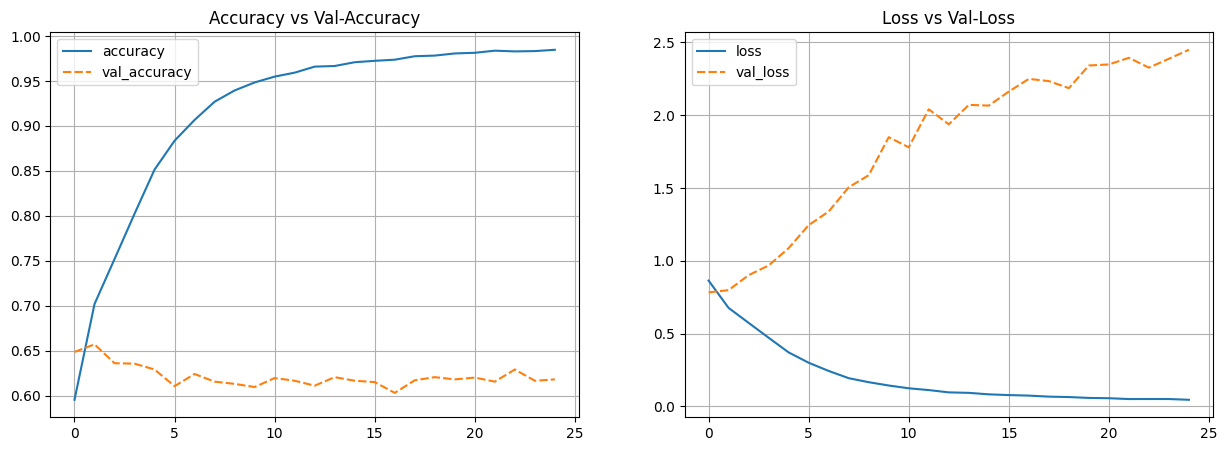

In [56]:


tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_data_processning)

# Convert text to sequence
X_train_seq = tokenizer.texts_to_sequences(train_data_processning)
X_val_seq = tokenizer.texts_to_sequences(val_data_processning)





# cleaning the invalide data
invalid_indices_train = [i for i, seq in enumerate(X_train_seq) if len(seq) == 0]
invalid_indices_val = [i for i, seq in enumerate(X_val_seq) if len(seq) == 0]

X_train_seq_clean = [seq for i, seq in enumerate(X_train_seq) if i not in invalid_indices_train]
y_train_ohe_clean = np.delete(train_data1_label, invalid_indices_train, axis=0)


X_val_seq_clean = [seq for i, seq in enumerate(X_val_seq) if i not in invalid_indices_val]
y_val_ohe_clean = np.delete(val_data1_label, invalid_indices_val, axis=0)

# update index
max_seq_length = max(len(seq) for seq in X_train_seq_clean + X_val_seq_clean)
X_train_padded_clean = pad_sequences(X_train_seq_clean, maxlen=max_seq_length)
X_val_padded_clean = pad_sequences(X_val_seq_clean, maxlen=max_seq_length)

# update
y_train_ohe_clean = to_categorical(y_train_ohe_clean)
y_val_ohe_clean = to_categorical(y_val_ohe_clean)

print("train data after cleaning:", len(X_train_seq_clean))
print("develop(val) data after cleaning:", len(X_val_seq_clean))




# # Fill the sequence
# max_seq_length = max(len(seq) for seq in X_train_seq + X_val_seq)
# X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length)
# X_val_padded = pad_sequences(X_val_seq, maxlen=max_seq_length)


# print("Max sequence length:", max_seq_length)

# # Convert target labels to one-hot encoding
# y_train_ohe = to_categorical(train_data1_label)
# y_val_ohe = to_categorical(val_data1_label)

# Define the architecture


learn_rate = tf.keras.optimizers.Adam(learning_rate =0.001)

model_lstm_1 = Sequential()
model_lstm_1.add(Embedding(input_dim=10000, output_dim=128, input_length=max_seq_length))
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))))
model_lstm_1.add(BatchNormalization())
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))))
model_lstm_1.add(BatchNormalization())
model_lstm_1.add(Dropout(0.1))
# model_lstm_1.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model_lstm_1.add(Dense(3, activation='softmax'))
model_lstm_1.compile(loss='categorical_crossentropy', optimizer=learn_rate, metrics=['accuracy'])
model_lstm_1.summary()
# Fit the model
# batch_size =32
batch_size =32
model_lstm_1_hist = model_lstm_1.fit(X_train_padded_clean,
                                     y_train_ohe_clean,
                                     epochs=25,
                                     batch_size=batch_size,
                                     validation_data=(X_val_padded_clean, y_val_ohe_clean))


# Plot training results
model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()


In [25]:

# Print training results
print("Training Results:")
print(model_lstm_1_hist_df[['accuracy', 'loss']])

print("\nValidation Results:")
print(model_lstm_1_hist_df[['val_accuracy', 'val_loss']])

Training Results:
    accuracy      loss
0   0.598939  0.859177
1   0.699961  0.680456
2   0.750822  0.577902
3   0.801925  0.473090
4   0.849301  0.370290
5   0.886044  0.290148
6   0.910400  0.231288
7   0.928005  0.192349
8   0.940610  0.157743
9   0.950147  0.137668
10  0.955036  0.126078
11  0.961657  0.106390
12  0.965537  0.095155
13  0.970075  0.086152
14  0.970623  0.082187
15  0.974196  0.072939
16  0.975095  0.071349
17  0.978844  0.063248
18  0.979305  0.059203
19  0.979699  0.056973
20  0.981519  0.053091
21  0.982571  0.053138
22  0.984413  0.046053
23  0.983075  0.049128
24  0.984347  0.046668
25  0.985816  0.043222
26  0.985925  0.041652
27  0.986320  0.041575
28  0.987811  0.035692
29  0.987942  0.035492
30  0.989521  0.032256
31  0.989038  0.033208
32  0.988775  0.035769
33  0.989981  0.030293
34  0.989872  0.029332
35  0.989345  0.032535
36  0.990748  0.027952
37  0.991362  0.026121
38  0.991231  0.027436
39  0.991143  0.026736
40  0.991735  0.025816
41  0.991603  0.

In [58]:
best_model_index = model_lstm_1_hist_df['val_accuracy'].idxmax()
best_model = model_lstm_1_hist_df.iloc[best_model_index]
print("Best Model Epoch:", best_model_index + 1)
print("Validation Accuracy:", best_model['val_accuracy'])
print("Validation Loss:", best_model['val_loss'])

# the best model information
print("\nBest Model Summary:")
best_model_summary = model_lstm_1.to_json()
print(best_model_summary)
# saving

# best_model.save("best_model_lstm_1.h5")




Best Model Epoch: 2
Validation Accuracy: 0.6570000052452087
Validation Loss: 0.7988604307174683

Best Model Summary:
{"class_name": "Sequential", "config": {"name": "sequential_13", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 32], "dtype": "float32", "sparse": false, "ragged": false, "name": "embedding_17_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Embedding", "config": {"name": "embedding_17", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 32], "input_dim": 10000, "output_dim": 128, "embeddings_initializer": {"module": "keras.initializers", "class_name": "RandomUniform", "config": {"minval": -0.05, "maxval": 0.05, "seed": null}, "registered_name": null}, "embeddings_regularizer": null, "activity_regularizer": null, "embeddings_constraint": null, "mask_zero": false, "input_length": 32}, "registered_name": null, "build_config": {"input_shape": [null, 32]}}, {"module": "keras